In [1]:
cd C:\Users\Majd Mustapha\DSP\AirlineSentimentAnalysis\

C:\Users\Majd Mustapha\DSP\AirlineSentimentAnalysis


In [36]:
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import lib.general_utilities as gu

from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression, RidgeClassifier, SGDClassifier
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier

from sklearn.model_selection import GridSearchCV, StratifiedShuffleSplit, train_test_split, cross_val_score
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import LabelEncoder

from sklearn.pipeline import make_pipeline, Pipeline

from collections import Counter
import itertools
from wordcloud import WordCloud
import seaborn as sns

from sklearn.metrics import classification_report,precision_recall_curve,confusion_matrix 
from sklearn.metrics import (precision_score,accuracy_score,roc_auc_score,roc_curve, 
                             precision_recall_curve,recall_score,make_scorer,auc)
from tqdm import tqdm

# storing data directories for this notebook.
img_out_dir = 'data/images/Modelling_NB3_70PercConf_withEmojiEncoding/CrossVal/'
data_out_dir = 'data/pickled/Modelling_NB3_70PercConf_withEmojiEncoding/CrossVal/'

%matplotlib inline

## This data was processed with emojis encoded as individual features. Let's see how the models do. Using 70% sentiment classification confidence level.

## Let's run our text data, through some models and see how they predict.

```At this point I have the following data that I want to compare results for:```
```
1. raw text
2. cleaned text
3. stopwords processed and cleaned text
4. stemmed, stopwords processed and cleaned text```

In [37]:
#***********************************************************************************

In [38]:
# Load pickled dataset.
filename = 'data/processed_dataset_df/airline_proc_dataset_70percCL_withEmEnc_addLemma_df'
air_full_df = gu.read_pickle_obj(filename)

In [39]:
air_full_df.head(11)

airline airline_sentiment  \
0   Virgin America           neutral   
1   Virgin America          negative   
2   Virgin America          negative   
3   Virgin America          negative   
4   Virgin America          positive   
5   Virgin America          positive   
6   Virgin America          positive   
7   Virgin America          positive   
8   Virgin America          positive   
9   Virgin America          negative   
10  Virgin America          positive   

                                                 text  \
0                 @VirginAmerica What @dhepburn said.   
1   @VirginAmerica it's really aggressive to blast...   
2   @VirginAmerica and it's a really big bad thing...   
3   @VirginAmerica seriously would pay $30 a fligh...   
4   @VirginAmerica it was amazing, and arrived an ...   
5   @VirginAmerica I &lt;3 pretty graphics. so muc...   
6   @VirginAmerica This is such a great deal! Alre...   
7                              @VirginAmerica Thanks!   
8   @VirginAmerica So excited for my first cross c...   
9   @VirginAmerica  I flew from NYC to SFO last we...   
10                    I ❤️ flying @VirginAmerica. ☺️👍   

                                           clean_text  \
0                                           what said   
1   its really aggressive to blast obnoxious enter...   
2             and its a really big bad thing about it   
3   seriously would pay 30 a flight for seats that...   
4   it was amazing and arrived an hour early youre...   
5   i lt3 pretty graphics so much better than mini...   
6   this is such a great deal already thinking abo...   
7                                              thanks   
8   so excited for my first cross country flight l...   
9   i flew from nyc to sfo last week and couldnt f...   
10               i  EMOJI_1️ flying  EMOJI_2️ EMOJI_3   

                                     stopw_clean_text  \
0                                                said   
1   really aggressive blast obnoxious entertainmen...   
2                                really big bad thing   
3   seriously pay 30 seats didnt playing really ba...   
4               amazing arrived hour early youre good   
5    lt3 pretty graphics better minimal iconography d   
6   great deal thinking 2nd trip havent gone 1st t...   
7                                              thanks   
8   excited cross country lax mco ive heard great ...   
9   flew nyc sfo week fully sit seat large gentlem...   
10                   EMOJI_1️ flying EMOJI_2️ EMOJI_3   

                                stem_stopw_clean_text  \
0                                                said   
1   realli aggress blast obnoxi entertain guest fa...   
2                                realli big bad thing   
3   serious pay 30 seat didnt play realli bad thin...   
4                     amaz arriv hour earli your good   
5       lt3 pretti graphic better minim iconographi d   
6    great deal think 2nd trip havent gone 1st trip p   
7                                               thank   
8   excit cross countri lax mco ive heard great th...   
9   flew nyc sfo week fulli sit seat larg gentlema...   
10                      emoji_1️ fli emoji_2️ emoji_3   

                               lemma_stopw_clean_text negativereason  \
0                                                said            NaN   
1   really aggressive blast obnoxious entertainmen...     Bad Flight   
2                                really big bad thing     Can't Tell   
3   seriously would pay 30 flight seat didnt playi...     Can't Tell   
4               amazing arrived hour early youre good            NaN   
5   lt3 pretty graphic much better minimal iconogr...            NaN   
6   great deal already thinking 2nd trip amp haven...            NaN   
7                                              thanks            NaN   
8   excited first cross country flight lax mco ive...            NaN   
9   flew nyc sfo last week couldnt fully sit seat ...     Bad Flight  

In [40]:
# dataset size.
air_full_df.shape

(10768, 9)

In [72]:
# column names
air_full_df.columns

Index(['airline', 'airline_sentiment', 'text', 'clean_text',
       'stopw_clean_text', 'stem_stopw_clean_text', 'emojis', 'negativereason',
       'airline_sentiment_confidence', 'lemma_stopw_clean_text'],
      dtype='object')

In [73]:
# airlines.
air_full_df.airline.unique()

array(['Virgin America', 'United', 'Southwest', 'Delta', 'US Airways',
       'American'], dtype=object)

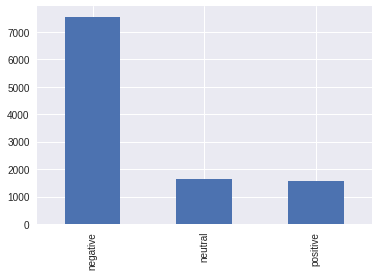

In [74]:
air_full_df.airline_sentiment.value_counts().plot(kind='bar')

In [75]:
#****** Highly imbalanced. 

In [6]:
def log_output(dataset_name, model_name, sc_output, pipe):
    '''
    This method logs the output of a model pipeline.
    '''
    
    entry = {                
                'dataset'        :  dataset_name,
                'model'          :  model_name,
                'tr_acc_score'   :  sc_output['train_score'],
                'tst_acc_score'  :  sc_output['test_score'],
                'pipe_object'    :  pipe,
                'y_pred'         :  sc_output['y_pred'],
                'ypred_proba'    :  sc_output['ypred_proba'],
                'ytest'          :  sc_output['ytest']
            }
    return(entry)

In [7]:
# fit score pipeline of models. Good for benchmarking.
def fit_score_pipeline(pipe, X, y, target_names):
    '''
    This method fits and scores pipeline of models. Its good for benchmarking.
    '''    
  
    # train test split our X and y.
    Xtrain, Xtest, ytrain, ytest = train_test_split(X, 
                                                    y, 
                                                    test_size=.2, 
                                                    random_state=42)
    # Fit and score pipeline.
    pipe.fit(Xtrain, ytrain) 
    
    # Use cross validation to get a mean accuracy score of model.
    scores = []
    scores = cross_val_score(pipe, Xtrain, ytrain, cv=5, scoring='accuracy')
    train_score = scores.mean()
    
    scores = []
    scores = cross_val_score(pipe, Xtest, ytest, cv=5, scoring='accuracy')
    test_score = scores.mean()
    y_pred = pipe.predict(Xtest)
    ypred_proba = pipe.predict_proba(Xtest)
        
    output = {'train_score':train_score, 
              'test_score' :test_score,
              'y_pred'     :y_pred,
              'ytest'      :ytest,
              'ypred_proba':ypred_proba 
              }  
    
    #classification reports. 
    class_report_str = classification_report(ytest, y_pred, target_names=target_names)
    
    #confusion matrix.
    conf_matrix_raw = confusion_matrix(ytest, y_pred)
    
    return(output, class_report_str, conf_matrix_raw)

In [8]:
def execute_pipeline(pipe, param_grid, X, y, target_names, model_results, model_name,
                     classification_rep, confusion_mtx, data_desc):
    '''
    This method manages the pipeline fit and score execution, and keeps track of logging
    the results.  
    '''
                                    
    # Fit, score and get model stats.                                           
    sc_output, cl_report_str, conf_mtx = fit_score_pipeline(pipe, 
                                                            X,
                                                            y,
                                                            target_names=target_names)
       
    # Save classification report and confusion matrix, scaled data.
    key = model_name+" "+data_desc
    classification_rep[key] = cl_report_str
    key = model_name+" "+data_desc
    confusion_mtx[key] = conf_mtx
    
    # Log results.
    entry = log_output( dataset_name = data_desc, 
                        model_name   = model_name, 
                        sc_output    = sc_output,
                        pipe         = pipe)

    # Append the output for this model to a list.
    model_results.append(entry)

In [9]:
def plot_confusion_matrix(cm, classes,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues,
                          isNorm = False):
    '''
    This function plots and saves the confusion matrix.
    '''
    
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    plt.grid('off')

    if (isNorm):
        cm = np.round(cm.astype('float') / cm.sum(axis=1)[:, np.newaxis], 2)
        print("Normalized confusion matrix")
        print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="red")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')    
    plt.savefig(img_out_dir+'BM_'+title+'.png')   
    plt.show()

In [10]:
def classifaction_report_df(report):
    report_data = []
    lines = report.split('\n')
    for line in lines[2:-3]:
        row = {}
        row_data = line.split('      ')
        row['class'] = row_data[0]
        row['precision'] = float(row_data[1])
        row['recall'] = float(row_data[2])
        row['f1_score'] = float(row_data[3])
        row['support'] = float(row_data[4])
        report_data.append(row)
    dataframe = pd.DataFrame.from_dict(report_data)
    return(dataframe)

In [11]:
def plot_point(data, x, y, hue, title):    
    plt.figure(figsize=(8, 6))
    sns.pointplot(x=x, y=y, hue=hue, data=data)
    plt.xticks(rotation=90, fontsize=12)
    plt.xlabel(x, fontsize=12)
    plt.ylabel(y, fontsize=12)
    plt.title(title)
    plt.tight_layout()

In [12]:
def plot_bar(data, x, y, hue, title):    
    plt.figure(figsize=(8, 6))
    sns.barplot(x=x, y=y, hue=hue, data=data)
    plt.xticks(rotation=90, fontsize=12)
    plt.xlabel(x, fontsize=12)
    plt.ylabel(y, fontsize=12)
    plt.title(title)
    plt.tight_layout()

In [13]:
def plot_ROC(fpr,tpr,title, roc_auc):
    plt.title('Receiver Operating Characteristic '+title)
    plt.plot(fpr, tpr, 'b',
    label='AUC = %0.2f'% roc_auc)
    plt.legend(loc='lower right')
    plt.plot([0,1],[0,1],'r--')
    plt.xlim([-0.1,1.2])
    plt.ylim([-0.1,1.2])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.savefig(img_out_dir+'BM_ROC_'+title+'.png')
    plt.show()

### Let's see what is the accuracy that could be achieved by simply always predicting the most frequent class.
Target is ```airline sentiment```

In [14]:
y = air_full_df['airline_sentiment']

In [15]:
y.value_counts()

negative    7552
neutral     1634
positive    1582
Name: airline_sentiment, dtype: int64

In [16]:
yvalcnts = y.value_counts()
yvalcnts[0]/sum(yvalcnts)

0.70133729569093606

```Since this is a highly imbalanced dataset we see that:
A naive model that always predicts the'negative class' would be right 70% of the time.
This shows how classification accuracy may not be the best metric to score our model.
However it gives us a baseline of the least we should expect from our models.```

### Encode the target labels. 

In [17]:
# target.
y = air_full_df['airline_sentiment']

In [18]:
y.unique()

array(['neutral', 'negative', 'positive'], dtype=object)

In [19]:
# Encode the target categories to a numeric number, using one hot encoding.
encoder = LabelEncoder()
y = encoder.fit_transform(air_full_df['airline_sentiment'])

In [20]:
encoder.classes_

array(['negative', 'neutral', 'positive'], dtype=object)

In [21]:
# value counts of each class.
Counter(y)

Counter({0: 7552, 1: 1634, 2: 1582})

In [22]:
# 0:Negative, 1:neutral, 2:positive
# Classes of training data are imbalanced. 

In [23]:
# Create a document token matrix with CountVectorizer here. We are creating a numerical 
# representation of the words based on their count frequency in the 
# documents(in this case tweets)

In [24]:
# NOTE: RUN MODELS WITH CLEAN, STOPW_CLEAN and STEM_STOPW_CLEAN, text. Is there a difference
# in accuracy?

In [25]:
# NOTE: Analyze why I selected to run these.

## Create pipeline for running models.

In [41]:
# Make a dictionary of models to run.
# Using high C value for SVC and LR to provide minimal regularization.
modelsToexecute_dict = {'NaiveBayes': {'model':MultinomialNB(),
                                        'param_grid': ''},
                 'LogisticRegression': {'model':LogisticRegression(C=1000),
                                        'param_grid':''}                     
                       }

In [42]:
# Save mean accuracy scores, classification reports and confusion matrix.
model_results = []
confusion_mtx = {}
classification_rep = {}
cv_vectorizers = []
target_names=['negative', 'neutral', 'positive']

In [43]:
data_to_use = ['clean_text', 'stopw_clean_text', 'stem_stopw_clean_text', 'lemma_stopw_clean_text']
data_desc = ["clean text", "remove stopwords", "applied stemming", "lemmatized"]

In [44]:
for ind, text_set in tqdm(enumerate(data_to_use)):
    print("text data used for this iteration: "+ text_set)
    # feature extraction.
    X = air_full_df[text_set] 
    
    for model_name, params in modelsToexecute_dict.items():  
        print("trainiing model: "+ model_name)
        model = params['model']
        param_grid = params['param_grid']
        
        # Create a pipeline for the model.
        #pipe = make_pipeline(model)
        pipe = Pipeline([
                          ('vec', CountVectorizer()),
                          ('model', model)
                        ])

                
        execute_pipeline(pipe, param_grid, X, y, target_names, model_results, model_name,
                         classification_rep, confusion_mtx, data_desc[ind])
        

0it [00:00, ?it/s]

text data used for this iteration: clean_text
trainiing model: NaiveBayes
trainiing model: LogisticRegression


1it [00:05,  5.94s/it]

text data used for this iteration: stopw_clean_text
trainiing model: NaiveBayes
trainiing model: LogisticRegression


2it [00:09,  4.67s/it]

text data used for this iteration: stem_stopw_clean_text
trainiing model: NaiveBayes
trainiing model: LogisticRegression


3it [00:12,  4.21s/it]

text data used for this iteration: lemma_stopw_clean_text
trainiing model: NaiveBayes
trainiing model: LogisticRegression


4it [00:16,  4.09s/it]


In [45]:
# Put all modelling results in a dataframe.
model_results_df = pd.DataFrame(model_results)

# I am specifying the column arrangements.
model_results_df = model_results_df[['dataset', 'model', 'tr_acc_score', 'tst_acc_score',
                                     'pipe_object', 'y_pred', 'ytest', 'ypred_proba']]

In [46]:
# classification reports are returned by sklearn as a string.
# make it into a dataframe.
cl_report_df = pd.DataFrame()
dframes = []
for k,v in classification_rep.items():

    df = classifaction_report_df(v)    
    modname_desc = k.split()
    
    df['model'] = str(modname_desc[0])
    df['data_desc'] = str(' '.join(modname_desc[1:]))
    dframes.append(df)
    #print('*****  ' + k + '  Classification Report *****', '\n\n', v, '\n')
    
cl_report_df = pd.concat(dframes)
cl_report_df.reset_index(inplace=True)
cl_report_df.drop("index", axis=1, inplace=True)

In [47]:
# pickle benchmark results.

gu.pickle_obj(data_out_dir+'benchmark_model_results_ngrams1_1_df', model_results_df)
gu.pickle_obj(data_out_dir+'benchmark_count_vectorizers_ngrams1_1.obj', cv_vectorizers)
gu.pickle_obj(data_out_dir+'benchmark_class_report_ngrams1_1_df.obj', cl_report_df)
gu.pickle_obj(data_out_dir+'benchmark_class_report_sklearn_ngrams1_1.obj', classification_rep)

In [48]:
model_results_df

dataset               model  tr_acc_score  tst_acc_score  \
0        clean text          NaiveBayes      0.819018       0.759989   
1        clean text  LogisticRegression      0.842467       0.822660   
2  remove stopwords          NaiveBayes      0.821571       0.781804   
3  remove stopwords  LogisticRegression      0.811470       0.789226   
4  applied stemming          NaiveBayes      0.816578       0.784126   
5  applied stemming  LogisticRegression      0.803110       0.765557   
6        lemmatized          NaiveBayes      0.823545       0.782738   
7        lemmatized  LogisticRegression      0.825629       0.792010   

                                         pipe_object  \
0  Pipeline(steps=[('vec', CountVectorizer(analyz...   
1  Pipeline(steps=[('vec', CountVectorizer(analyz...   
2  Pipeline(steps=[('vec', CountVectorizer(analyz...   
3  Pipeline(steps=[('vec', CountVectorizer(analyz...   
4  Pipeline(steps=[('vec', CountVectorizer(analyz...   
5  Pipeline(steps=[('vec', CountVectorizer(analyz...   
6  Pipeline(steps=[('vec', CountVectorizer(analyz...   
7  Pipeline(steps=[('vec', CountVectorizer(analyz...   

                                              y_pred  \
0  [1, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 2, 0, ...   
1  [1, 0, 2, 0, 0, 0, 0, 2, 0, 0, 2, 1, 2, 2, 0, ...   
2  [1, 0, 2, 0, 0, 0, 0, 2, 0, 0, 0, 1, 0, 2, 0, ...   
3  [1, 0, 2, 0, 0, 1, 0, 2, 0, 0, 2, 1, 0, 2, 0, ...   
4  [1, 0, 2, 0, 0, 0, 0, 2, 0, 0, 0, 1, 0, 2, 0, ...   
5  [1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 2, 1, 0, 2, 0, ...   
6  [1, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 2, 0, ...   
7  [1, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 1, 2, 2, 0, ...   

                                               ytest  \
0  [1, 1, 2, 0, 0, 0, 0, 2, 0, 0, 0, 1, 0, 2, 0, ...   
1  [1, 1, 2, 0, 0, 0, 0, 2, 0, 0, 0, 1, 0, 2, 0, ...   
2  [1, 1, 2, 0, 0, 0, 0, 2, 0, 0, 0, 1, 0, 2, 0, ...   
3  [1, 1, 2, 0, 0, 0, 0, 2, 0, 0, 0, 1, 0, 2, 0, ...   
4  [1, 1, 2, 0, 0, 0, 0, 2, 0, 0, 0, 1, 0, 2, 0, ...   
5  [1, 1, 2, 0, 0, 0, 0, 2, 0, 0, 0, 1, 0, 2, 0, ...   
6  [1, 1, 2, 0, 0, 0, 0, 2, 0, 0, 0, 1, 0, 2, 0, ...   
7  [1, 1, 2, 0, 0, 0, 0, 2, 0, 0, 0, 1, 0, 2, 0, ...   

                                         ypred_proba  
0  [[0.285214672448, 0.694994783444, 0.0197905441...  
1  [[0.000201519321423, 0.999793825176, 4.6555023...  
2  [[0.257898587889, 0.589837351043, 0.1522640610...  
3  [[0.108289542889, 0.883826950076, 0.0078835070...  
4  [[0.207859209908, 0.635047281724, 0.1570935083...  
5  [[0.0503969095076, 0.936909231229, 0.012693859...  
6  [[0.225163515903, 0.617316700284, 0.1575197838...  
7  [[0.0156412156119, 0.966746220879, 0.017612563...

In [49]:
cl_report_df.head(5)

class  f1_score  precision  recall  support               model  \
0     negative      0.89       0.81    0.99   1500.0          NaiveBayes   
1      neutral      0.46       0.85    0.31    350.0          NaiveBayes   
2     positive      0.70       0.91    0.57    304.0          NaiveBayes   
3     negative      0.90       0.90    0.90   1500.0  LogisticRegression   
4      neutral      0.66       0.65    0.66    350.0  LogisticRegression   

    data_desc  
0  clean text  
1  clean text  
2  clean text  
3  clean text  
4  clean text

## Visualize Classification Report Metrics.

### Accuracy of model for the different feature dimensions of the text data
```text data: cleaned only, stopwords added, stemming added.```

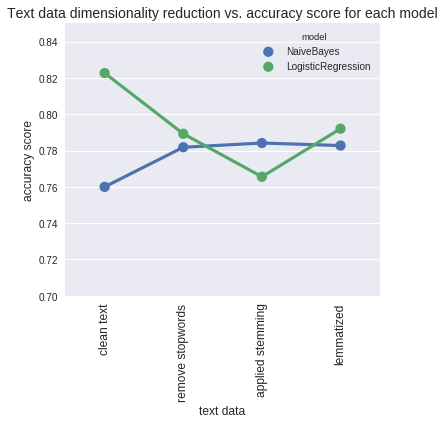

In [50]:
plt.figure(figsize=(6,6))
sns.pointplot(x="dataset", y= "tst_acc_score", hue="model", data=model_results_df)
plt.title('Text data dimensionality reduction vs. accuracy score for each model',
          fontsize=14)
plt.xlabel('text data', fontsize=12)
plt.xticks(rotation=90, fontsize=12)
plt.ylabel('accuracy score', fontsize=12)
plt.ylim(.7,.85)
plt.tight_layout()
plt.savefig(img_out_dir+'BM_model_accuracy_vs_feat_dim_reduction.png')

### Let's look at the classification report metrics: precision and recall, and confusion matrix

In [51]:
def plot_model_precision_recall(data, filename, data_type):
    plt.figure(figsize=(12,6))
    
    # plot precision.
    plt.subplot(1,2,1)
    sns.pointplot(x="model", y= "precision", hue="class", data=data)
    plt.title('Text data: ('+data_type+') vs. precision score for each model',
              fontsize=14)
    plt.xlabel('models', fontsize=12)
    plt.xticks(rotation=90,fontsize=12)
    plt.ylabel('precision score', fontsize=12)

    # plot recall.
    plt.subplot(1,2,2)
    sns.pointplot(x="model", y= "recall", hue="class", data=data)
    plt.title('Text data: ('+data_type+') vs. recall score for each model',
              fontsize=14)
    plt.xlabel('models', fontsize=12)
    plt.xticks(rotation=90,fontsize=12)
    plt.ylabel('recall score', fontsize=12)

    plt.tight_layout()
    plt.savefig(img_out_dir+filename)

In [52]:
data_desc = ["clean text", "remove stopwords", "applied stemming", "lemmatized"]

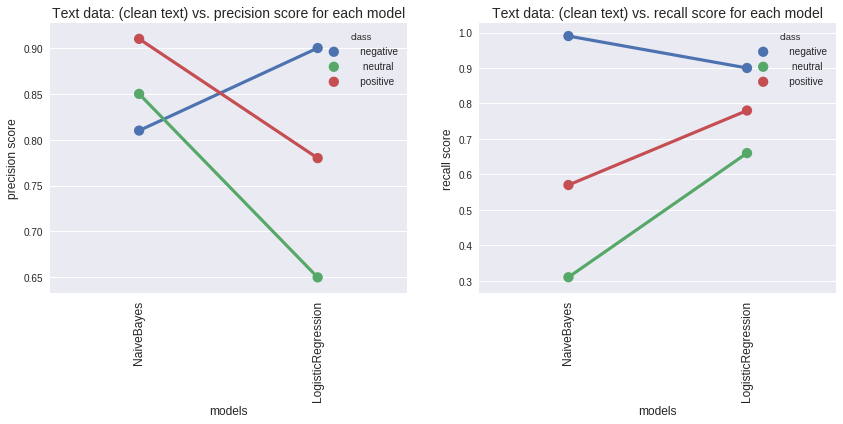

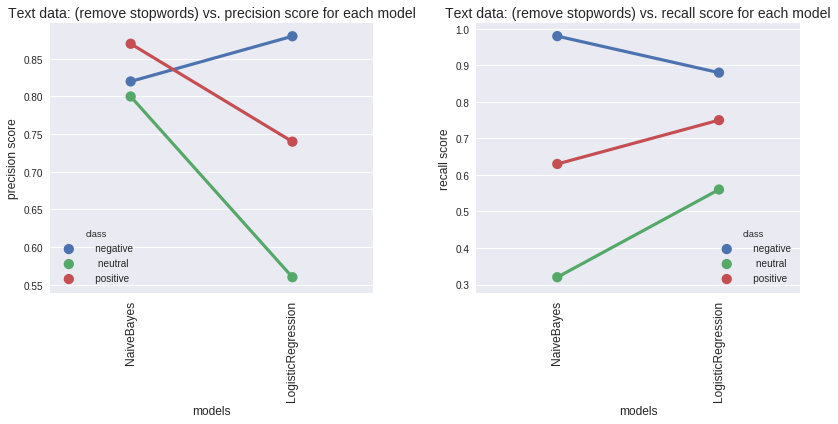

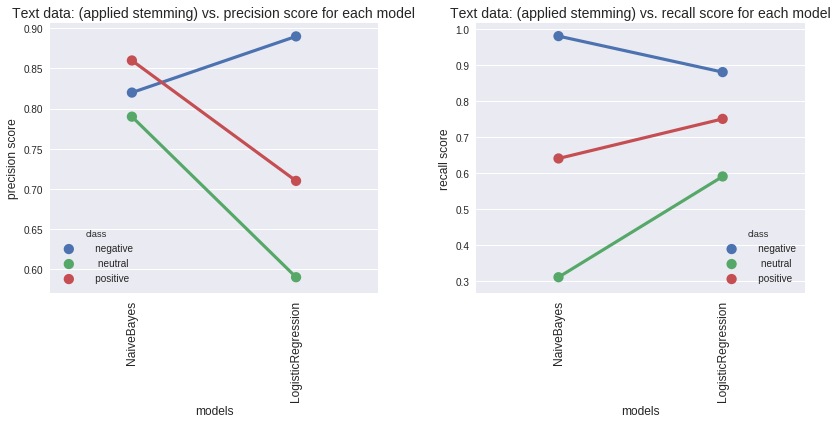

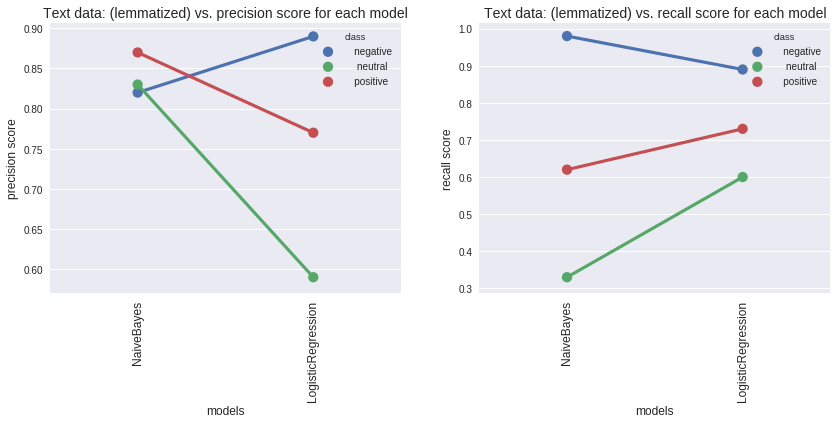

In [53]:
for data_type in data_desc:
    filename = 'BM_model_prec_recall_vs_models_'+data_type.replace(' ','')+'.png'
    data = cl_report_df[cl_report_df.data_desc==data_type]
    plot_model_precision_recall(data, filename, data_type)

In [344]:
# confusion matrix is used to evaluate the quality of the output of a classifier.
# The diagonal elements represent the number of points for which the predicted label 
# is equal to the true label, while off-diagonal elements are those that are mislabeled
# by the classifier.

In [41]:
# Metrics computed from a confusion matrix:

#    Classification Accuracy: Overall, how often is the classifier correct?
#    (TP + TN) / (TP + TN + FP + FN)

#    Classification Error: Overall, how often is the classifier incorrect?
#    (FP + FN) / (TP + TN + FP + FN)

#    Sensitivity: When the actual value is positive, how often is the prediction correct?
#    out of all positives, how many were true positives.
#    ***** This is Something we want to maximize. *****
#           How "sensitive" is the classifier to detecting positive instances?
#           Also known as "True Positive Rate" or "RECALL"
#                 TP / all positive
#                 all positive = TP + FN

#     Specificity: When the actual value is negative, how often is the prediction correct?
#     ***** This is Something we want to maximize. *****
#             How "specific" (or "selective") is the classifier in predicting positive instances?
#                 TN / all negative
#                 all negative = TN + FP

#     Precision: When a positive value is predicted, how often is the prediction correct?
#             How "precise" is the classifier when predicting positive instances?


Normalized confusion matrix
[[ 0.99  0.01  0.  ]
 [ 0.65  0.31  0.03]
 [ 0.41  0.02  0.57]]


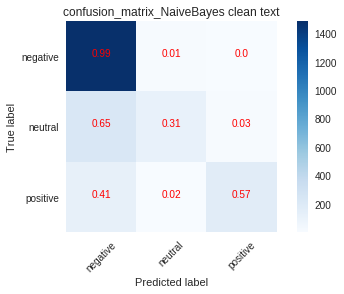

Normalized confusion matrix
[[ 0.9   0.07  0.03]
 [ 0.28  0.66  0.06]
 [ 0.15  0.07  0.78]]


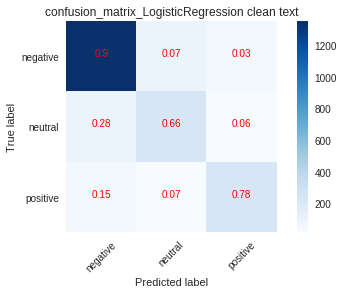

Normalized confusion matrix
[[ 0.98  0.01  0.01]
 [ 0.63  0.32  0.05]
 [ 0.34  0.03  0.63]]


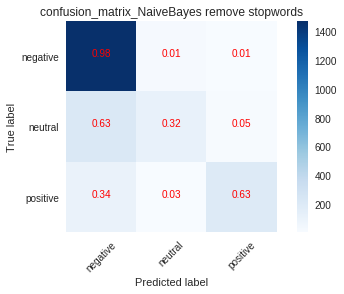

Normalized confusion matrix
[[ 0.88  0.08  0.03]
 [ 0.35  0.56  0.09]
 [ 0.17  0.08  0.75]]


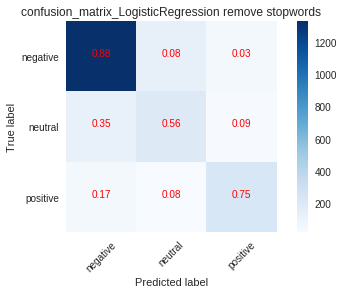

Normalized confusion matrix
[[ 0.98  0.01  0.01]
 [ 0.63  0.31  0.06]
 [ 0.33  0.03  0.64]]


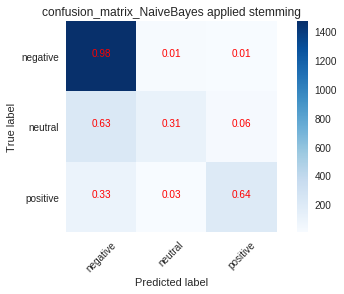

Normalized confusion matrix
[[ 0.88  0.08  0.04]
 [ 0.31  0.59  0.11]
 [ 0.18  0.08  0.75]]


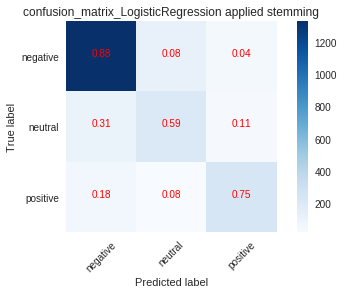

Normalized confusion matrix
[[ 0.98  0.01  0.01]
 [ 0.61  0.33  0.05]
 [ 0.35  0.03  0.62]]


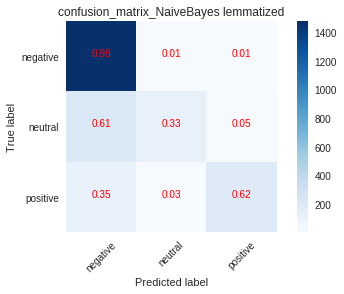

Normalized confusion matrix
[[ 0.89  0.08  0.03]
 [ 0.31  0.6   0.08]
 [ 0.18  0.08  0.73]]


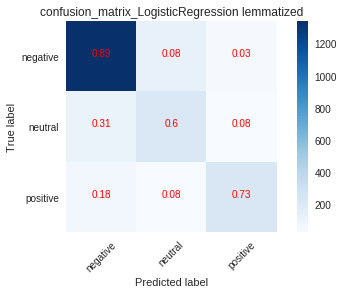

In [54]:
# Plot confusion matrices, for all models. Table that describes the performance of a classification model.
for k,conf_mtx in confusion_mtx.items():
    plot_confusion_matrix(conf_mtx, classes=target_names,
                          title= 'confusion_matrix_'+k,
                          isNorm='True')    

In [98]:
model_results_df.columns

Index(['dataset', 'model', 'tr_acc_score', 'tst_acc_score', 'pipe_object',
       'y_pred', 'ytest', 'ypred_proba'],
      dtype='object')

In [44]:
y_pred_prob = model_results_df.ypred_proba[0]

In [45]:
(model_results_df.y_pred[0]==0).sum(), (model_results_df.y_pred[0]==1).sum(), (model_results_df.y_pred[0]==2).sum()

(1757, 174, 223)

In [46]:
(model_results_df.ytest[0]==0).sum(), (model_results_df.ytest[0]==1).sum(), (model_results_df.ytest[0]==2).sum()

(1500, 350, 304)

In [47]:
y_test = model_results_df.ytest[0]

In [48]:
model_results_df.model[0]

'NaiveBayes'

In [49]:
# Predict sentiment of text.

In [50]:
nb_pipe = model_results_df.pipe_object[0]

In [51]:
nb_pipe.classes_

array([0, 1, 2])

In [59]:
X_in = cv.transform(["it was fairly nice amazing"])

In [60]:
nb_pipe.predict(X_in)

array([0])

In [ ]:
# naive bayes mispredicts the above text I made up, which is positive, as negative.
# text prediction is very subjective and hard to generalize. My guess is its easier 
# to predict when text is more domain specific.

In [61]:
prob = nb_pipe.predict_proba(X_in)

In [62]:
prob[0]

array([ 0.61845785,  0.04104215,  0.3405    ])

In [63]:
text = air_full_df[air_full_df.airline_sentiment == 'positive']['clean_text'].values[5]
text

'i  EMOJI_1️ flying  EMOJI_2️ EMOJI_3'

In [64]:
X_in = cv.transform([text])
prob = nb_pipe.predict_proba(X_in)
prob, nb_pipe.predict(X_in)

(array([[  6.01344417e-04,   4.86286957e-03,   9.94535786e-01]]), array([2]))

In [ ]:
#********* This line has a high number of emojis. naive bayes predicted positive. 
# If I check airline_sentiment_BenchMark_NB3, I see that naive bayes mispredicted 
# this positive tweet as negative, without the emojis.

# Emojis as perhaps one of the strongest predictors for the 'positive' class.
# Since the data is highly unbalanced towards the 'negative' class, anything
# we can do to help balance the training data, will help our model be a better
# sentiment predictor.

In [65]:
text = air_full_df[air_full_df.airline_sentiment == 'negative']['clean_text'].values[35]
text

'and now the flight flight booking problems site is totally down folks what is the problem'

In [66]:
X_in = cv.transform([text])
prob = nb_pipe.predict_proba(X_in)
prob, nb_pipe.predict(X_in)

(array([[  9.93689391e-01,   6.30309275e-03,   7.51642668e-06]]), array([0]))

In [67]:
# model predicts negative with strong class probability, as expected.

In [68]:
text = air_full_df[air_full_df.airline_sentiment == 'neutral']['clean_text'].values[35]
text

'to begin dallasaustin flights in april  889 ketr'

In [69]:
X_in = cv.transform([text])
prob = nb_pipe.predict_proba(X_in)
prob, nb_pipe.predict(X_in)

(array([[  1.09462127e-04,   9.96404067e-01,   3.48647073e-03]]), array([1]))

In [ ]:
# The model predicts the correct class 'neutral' with strong probability.